In [1]:
import os
import sys
sys.path.append('/Users/david/Desktop/FinetuneEmbed')
import json
import pickle
import mygene
# Specify the working directory
os.chdir('/Users/david/Desktop/FinetuneEmbed')
# os.chdir('/afs/crc.nd.edu/group/StatDataMine/dm011/Dailin_Gan/FinetuneEmbed')

# load auc curve information
with open(f"./res/2025_0526_11SLLMs_4tasks/NoPCA_CV_name_embedding_NoTruncation/long_vs_shortTF/bge-small-en-v1.5/random_state_41/LR_CV_roc_data.pkl", "rb") as fp:
    LLM1_run1 = pickle.load(fp)

with open(f"./res/2025_0526_11SLLMs_4tasks/NoPCA_CV_name_embedding_NoTruncation/long_vs_shortTF/bge-small-en-v1.5/random_state_42/LR_CV_roc_data.pkl", "rb") as fp:
    LLM1_run2 = pickle.load(fp)

LLM1 = [LLM1_run1, LLM1_run2]

# load auc curve information
with open(f"./res/2025_0526_11SLLMs_4tasks/NoPCA_CV_name_embedding_NoTruncation/long_vs_shortTF/biobert-base-cased-v1.1/random_state_41/LR_CV_roc_data.pkl", "rb") as fp:
    LLM2_run1 = pickle.load(fp)

with open(f"./res/2025_0526_11SLLMs_4tasks/NoPCA_CV_name_embedding_NoTruncation/long_vs_shortTF/biobert-base-cased-v1.1/random_state_42/LR_CV_roc_data.pkl", "rb") as fp:
    LLM2_run2 = pickle.load(fp)

LLM2 = [LLM2_run1, LLM2_run2]

all_model_runs = {
    "LLM1": LLM1,
    "LLM2": LLM2
}


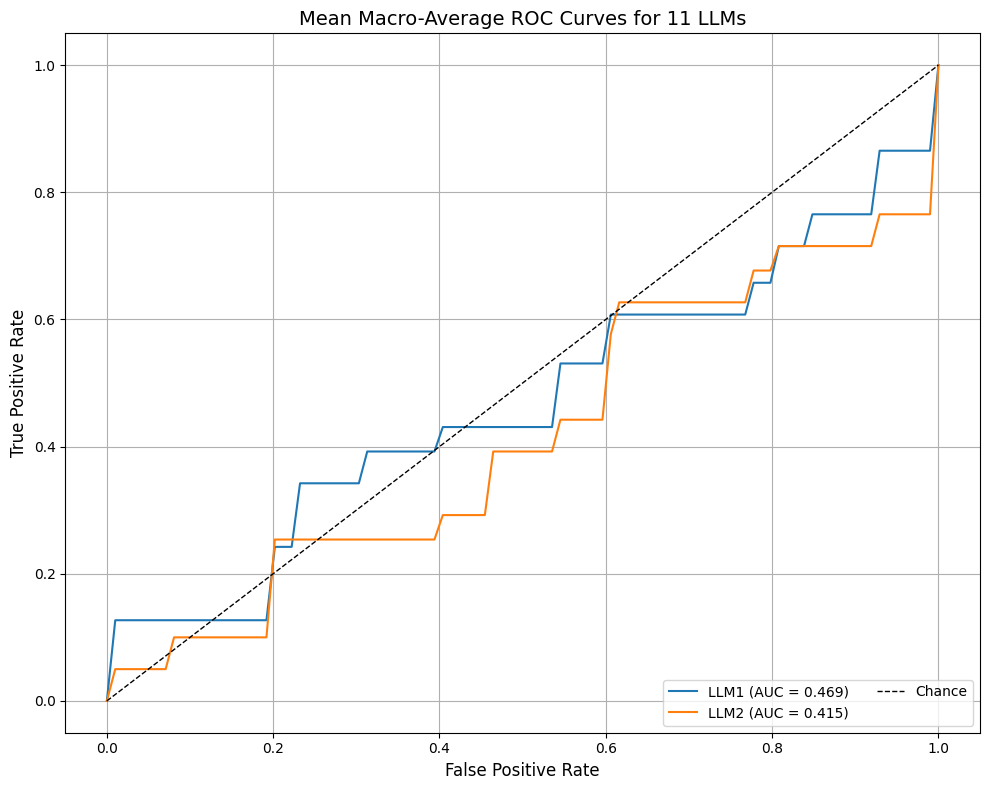

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr_common = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 8))

# Loop over each model
for model_name, runs in all_model_runs.items():
    tpr_macro_all = []
    auc_macro_all = []

    for run in runs:
        y_test_bin = run["y_test_bin"]
        y_test_proba = run["y_test_proba"]
        n_classes = y_test_proba.shape[1]

        # Binary safeguard
        if y_test_bin.ndim == 1 or y_test_bin.shape[1] == 1:
            y_test_bin = np.vstack((1 - y_test_bin, y_test_bin)).T
        if y_test_proba.ndim == 1 or y_test_proba.shape[1] == 1:
            y_test_proba = np.vstack((1 - y_test_proba, y_test_proba)).T

        tpr_per_class = []
        aucs = []

        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
            tpr_interp = np.interp(fpr_common, fpr, tpr)
            tpr_interp[0] = 0.0
            tpr_per_class.append(tpr_interp)
            aucs.append(auc(fpr, tpr))

        # Macro-average TPR and AUC
        tpr_macro = np.mean(tpr_per_class, axis=0)
        auc_macro = np.mean(aucs)
        tpr_macro_all.append(tpr_macro)
        auc_macro_all.append(auc_macro)

    # Compute overall mean across runs for this model
    mean_tpr = np.mean(tpr_macro_all, axis=0)
    mean_auc = np.mean(auc_macro_all)
    plt.plot(fpr_common, mean_tpr, label=f"{model_name} (AUC = {mean_auc:.3f})")

# Final plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Mean Macro-Average ROC Curves for 11 LLMs", fontsize=14)
plt.legend(loc="lower right", fontsize=10, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# runs: list of dicts with 'y_test_bin', 'y_test_proba', 'classes'
fpr_common = np.linspace(0, 1, 100)
tpr_macro_all = []
auc_macro_all = []

for run in runs:
    y_test_bin = run["y_test_bin"]
    y_test_proba = run["y_test_proba"]
    n_classes = y_test_proba.shape[1]

    # Ensure 2D shape (handle binary case)
    if y_test_bin.ndim == 1 or y_test_bin.shape[1] == 1:
        y_test_bin = np.vstack((1 - y_test_bin, y_test_bin)).T
    if y_test_proba.ndim == 1 or y_test_proba.shape[1] == 1:
        y_test_proba = np.vstack((1 - y_test_proba, y_test_proba)).T

    # Interpolate TPRs for each class
    tpr_per_class = []
    aucs = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        tpr_interp = np.interp(fpr_common, fpr, tpr)
        tpr_interp[0] = 0.0
        tpr_per_class.append(tpr_interp)
        aucs.append(auc(fpr, tpr))

    # Macro-average TPR and AUC for this run
    tpr_macro = np.mean(tpr_per_class, axis=0)
    auc_macro = np.mean(aucs)
    tpr_macro_all.append(tpr_macro)
    auc_macro_all.append(auc_macro)

# Final mean curve and AUC
mean_tpr = np.mean(tpr_macro_all, axis=0)
mean_auc = np.mean(auc_macro_all)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_common, mean_tpr, label=f"Macro-average ROC (AUC = {mean_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1, label="Chance")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Mean Macro-Average ROC Curve (10 Runs)", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_test_bin = data["y_test_bin"]
y_test_proba = data["y_test_proba"]
classes = data["classes"]

n_classes = len(classes)

# Multi-class ROC
if isinstance(y_test_bin, np.ndarray) and y_test_bin.ndim > 1:
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("Multi-class ROC Curve", fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Binary ROC
else:
    y_score = y_test_proba[:, 1] if y_test_proba.ndim > 1 else y_test_proba
    fpr, tpr, _ = roc_curve(y_test_bin, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("Binary ROC Curve", fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()